In [352]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from diffusion.models import CNN
from torch import nn
from PIL import Image
from torchvision import transforms

In [353]:
def get_probabilities_for_digit(model, images, device, digit=1):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Ensure the images are on the same device as the model
    images = images.to(device)
    
    # Pass the batch of images through the model
    outputs, _ = model(images)
    
    # Apply softmax to the outputs to get probabilities
    probabilities = nn.functional.softmax(outputs, dim=1)
    
    # Extract the probabilities for the given digit
    prob_digit = probabilities[:, digit]
    
    return prob_digit

def process_image(img_path):
    
    img = Image.open(img_path)
    img_gray = img.convert("L")
    digit_size = img_gray.size[0] // 6
    digits = []
    
    for i in range(6):
        for j in range(6):
            left = i * digit_size
            upper = j * digit_size
            right = left + digit_size
            lower = upper + digit_size
            digit = img_gray.crop((left, upper, right, lower))
            digit_resized = digit.resize((28, 28))
            digits.append(digit_resized)
            
    return digits

def plotting_mnist(directory, target_digit=1):
    
    device = "cuda:1"
    cnn = CNN().to(device)
    cnn.load_state_dict(torch.load('eval/models/epochs=10_cnn_weights.pt'))
    cnn.eval()
    
    def get_number_from_filename(filename):
        return int(filename.split("_")[1].split(".")[0])

    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    valid_images = [f for f in all_files]
    sorted_images = sorted(valid_images, key=get_number_from_filename)
    
    min_step = get_number_from_filename(sorted_images[0])
    max_step = get_number_from_filename(sorted_images[-1])
    
    desired_steps = [min_step]
    
    while desired_steps[-1] < max_step:
        desired_steps.append(desired_steps[-1] * 3)
    selected_images = [min(sorted_images, key=lambda img: abs(get_number_from_filename(img) - step)) for step in desired_steps]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # MNIST normalization
    ])

    plt.figure(figsize=(30, 30))
    for idx, img_path in enumerate(selected_images):
        digit_images = process_image(os.path.join(directory, img_path))
    
        probs = []
        
        with torch.no_grad():
            for digit_img in digit_images:
                input_tensor = transform(digit_img).unsqueeze(0).to(device)
                outputs = torch.nn.functional.softmax(cnn(input_tensor)[0], dim=1)
                prob = outputs[0][target_digit].item()
                probs.append(prob)
        
        avg_prob = sum(probs) / len(probs)
        
        plt.subplot(1, len(desired_steps), idx + 1)
        plt.imshow(np.array(Image.open(os.path.join(directory, img_path))))
        plt.title(f"Steps - {get_number_from_filename(img_path)} \n Avg. Prob for {target_digit}: {avg_prob:.4f}")
        plt.axis('off')
    plt.tight_layout()
    
    plt.show()

def process_cifar_image(img_path):
    # Since CIFAR images are already 32x32, we just open and return the image
    img = Image.open(img_path)
    return img

def plotting_cifar(directory, target_class=1):

    # Assuming the get_number_from_filename have a class indicator in the same format as before
    def get_number_from_filename(filename):
        return int(filename.split("_")[1].split(".")[0])

    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    valid_images = [f for f in all_files]
    sorted_images = sorted(valid_images, key=get_number_from_filename)
    
    min_step = get_number_from_filename(sorted_images[0])
    max_step = get_number_from_filename(sorted_images[-1])
    
    
    desired_steps = [min_step]
    while desired_steps[-1] < max_step:
        desired_steps.append(desired_steps[-1] * 3)

    selected_images = [min(sorted_images, key=lambda img: abs(get_number_from_filename(img) - step)) for step in desired_steps]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    plt.figure(figsize=(30, 30))
    
    for idx, img_path in enumerate(selected_images):
        image = process_cifar_image(os.path.join(directory, img_path))
        
        plt.subplot(1, len(selected_images), idx + 1)
        plt.imshow(np.array(image))
        plt.title(f"Image - Steps {get_number_from_filename(img_path)}")
        plt.axis('off')
        
    plt.tight_layout()
    
    plt.show()

# Example usage:
# plotting_cifar('path_to_cifar_images_directory', target_class=1)


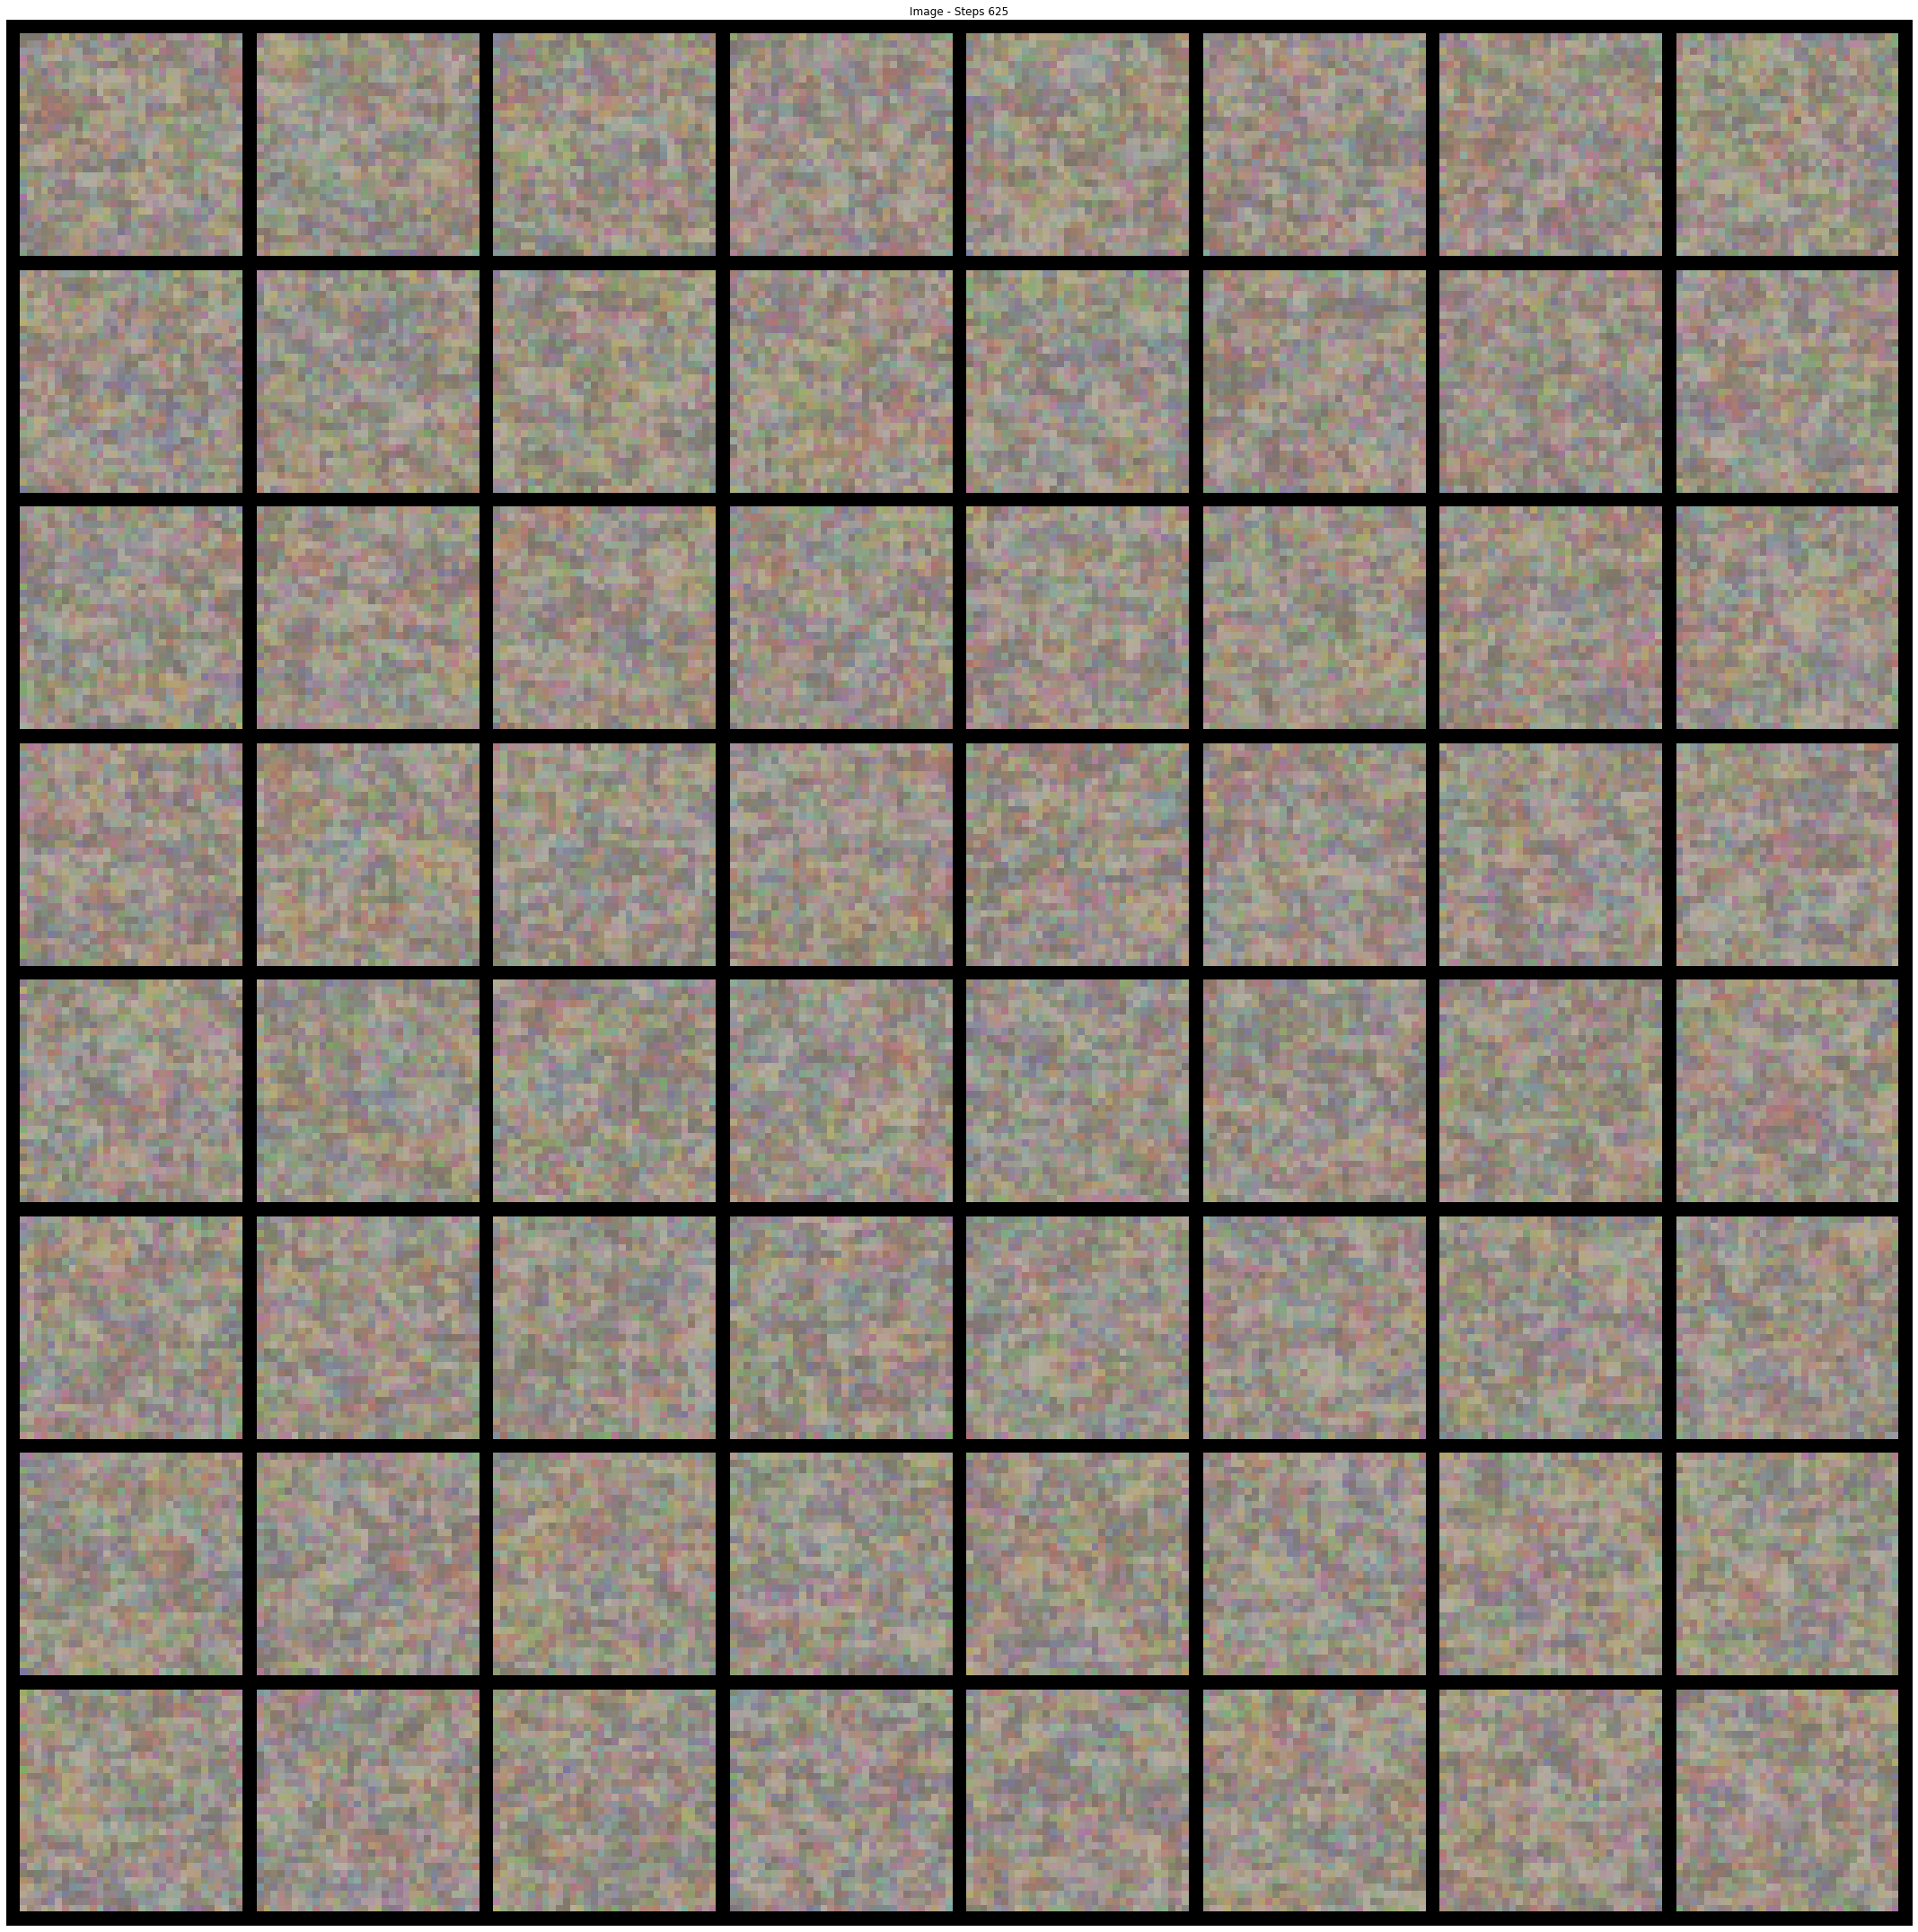

In [356]:
directory = "results/cifar/retrain/samples/full"
plotting_cifar(directory, digits)

# directory = "results/cifar/retrain/samples/9"
# plotting_mnist(directory, digits)

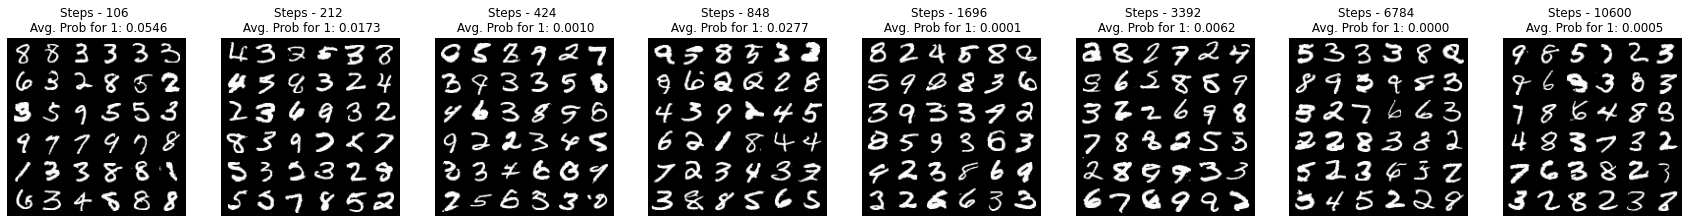

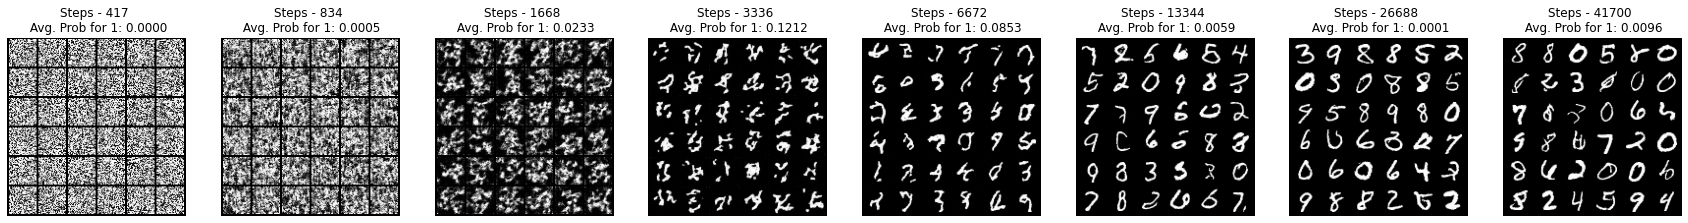

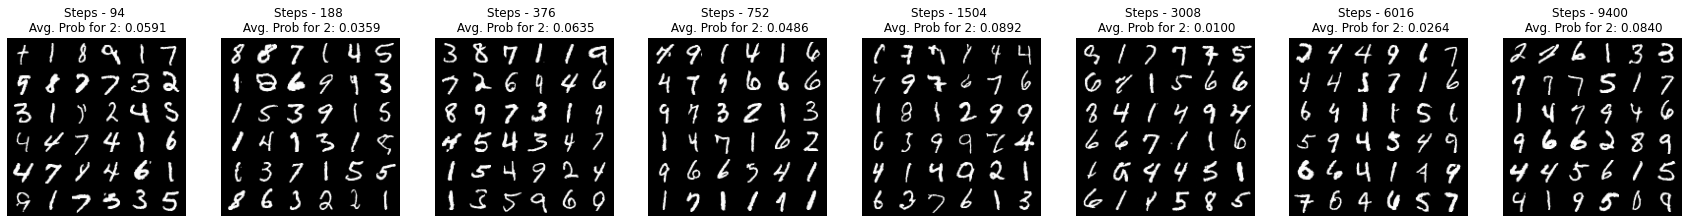

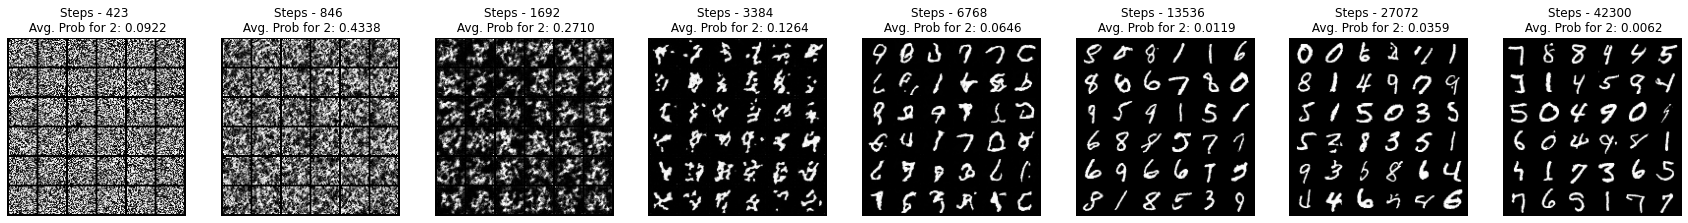

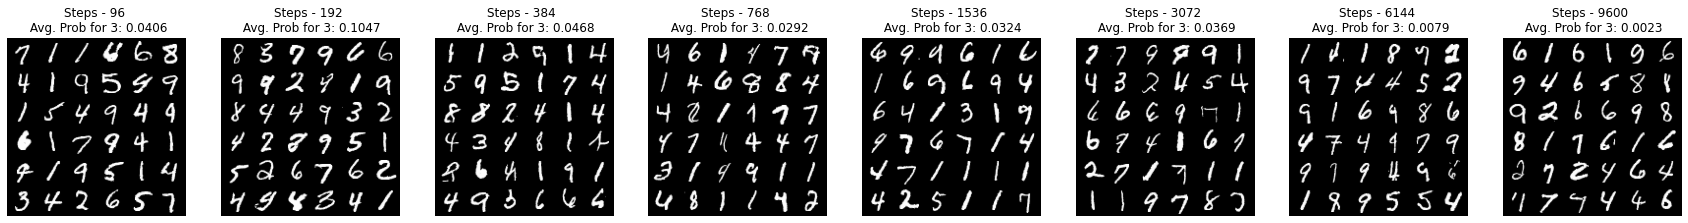

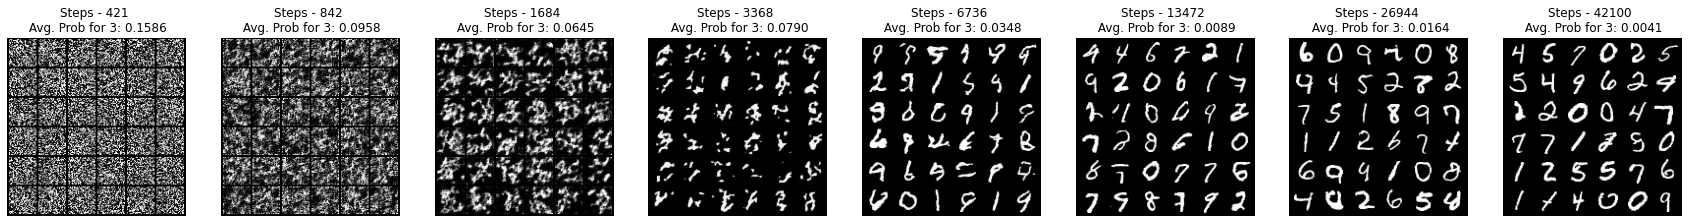

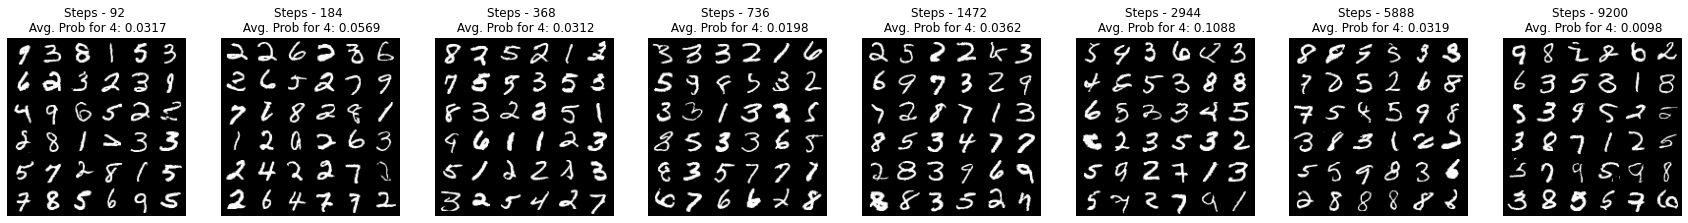

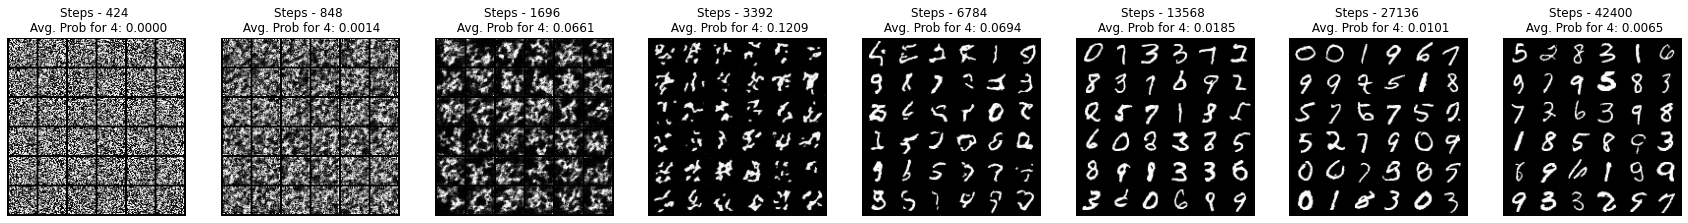

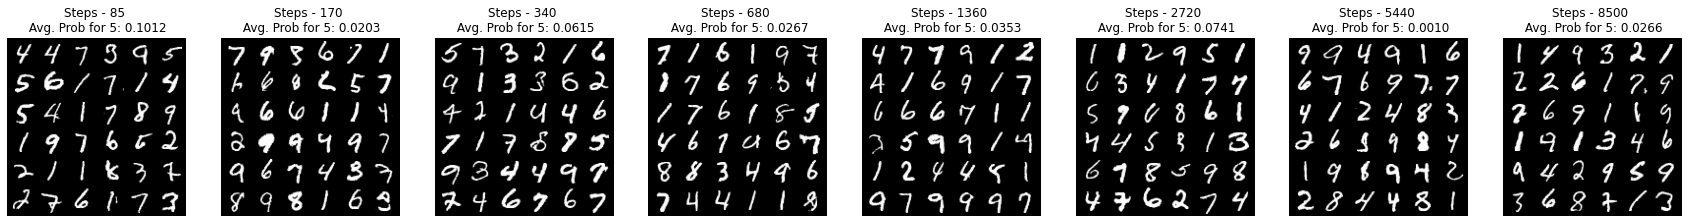

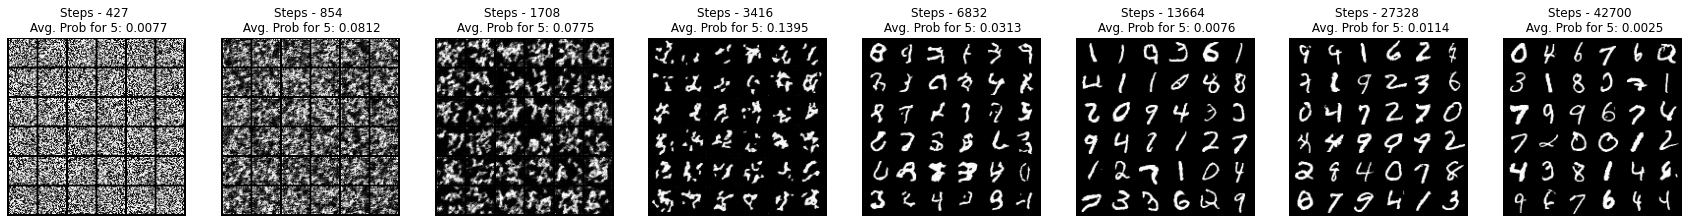

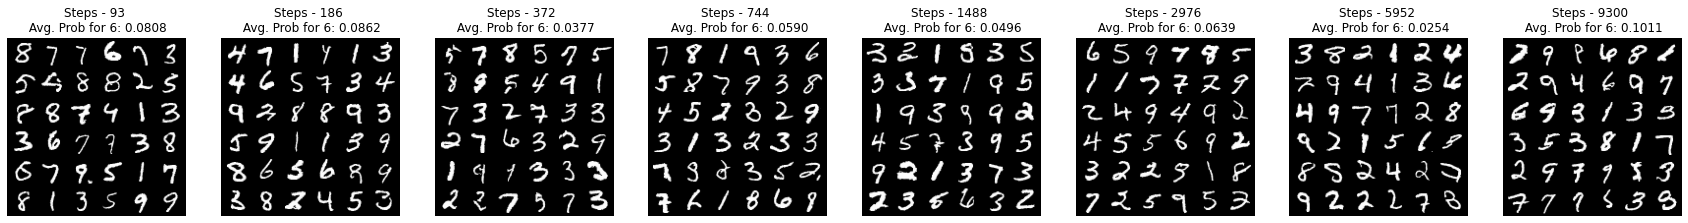

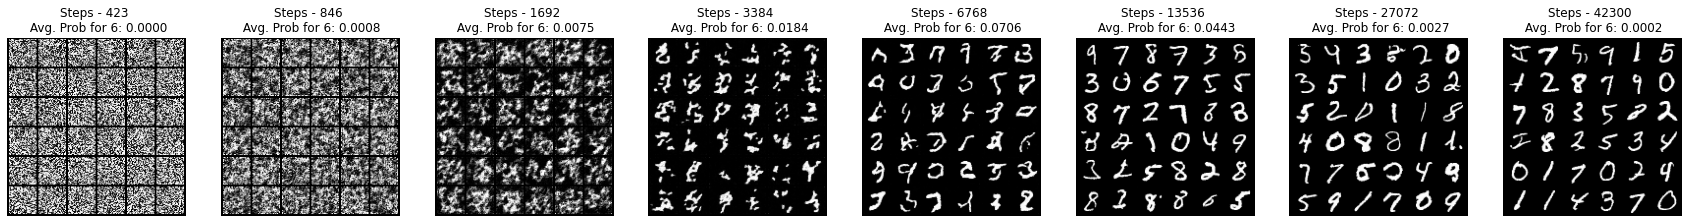

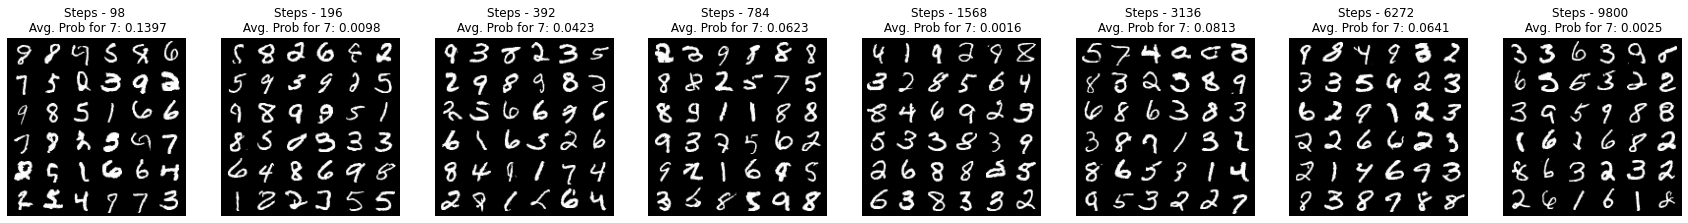

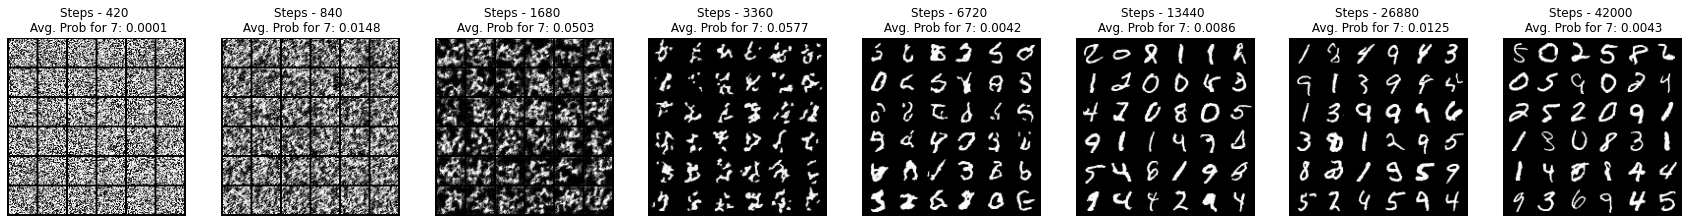

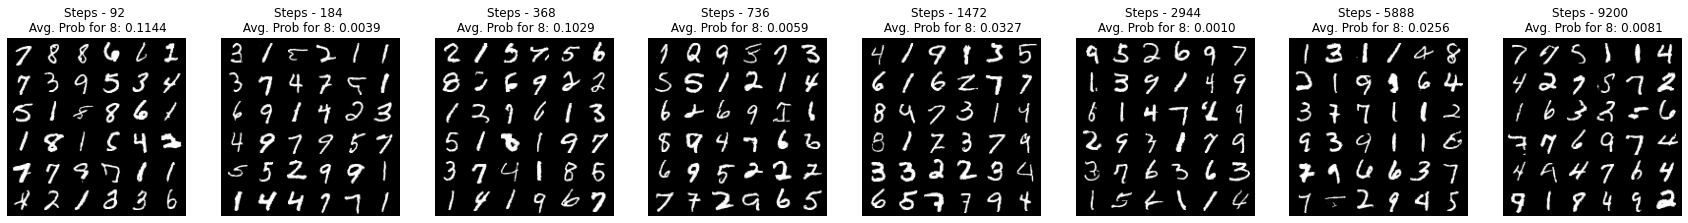

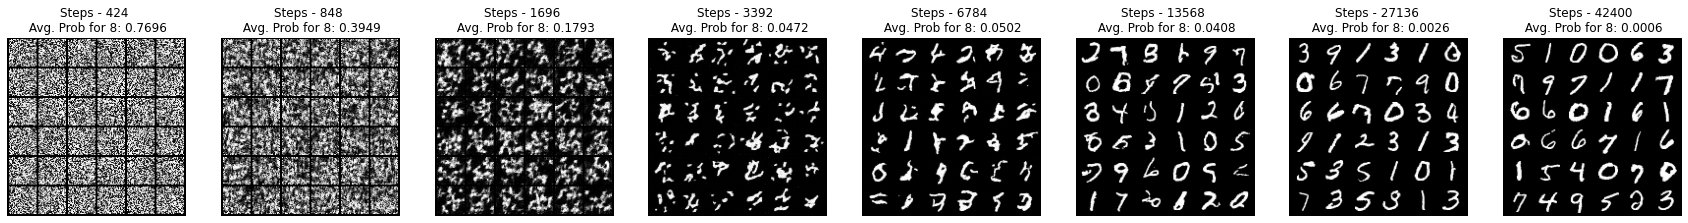

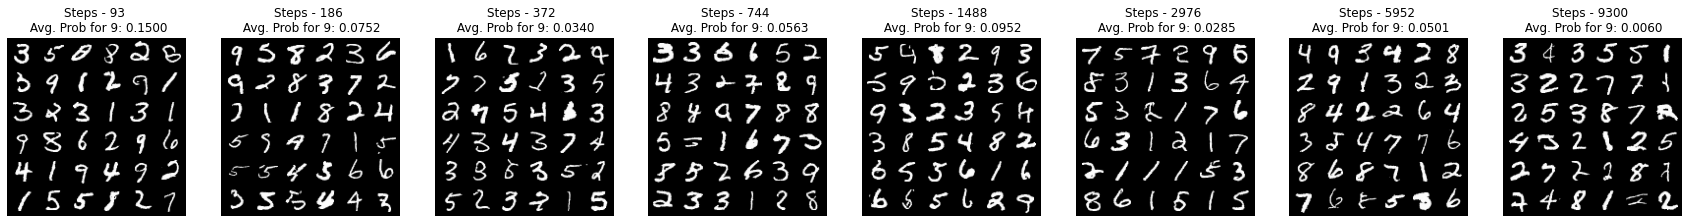

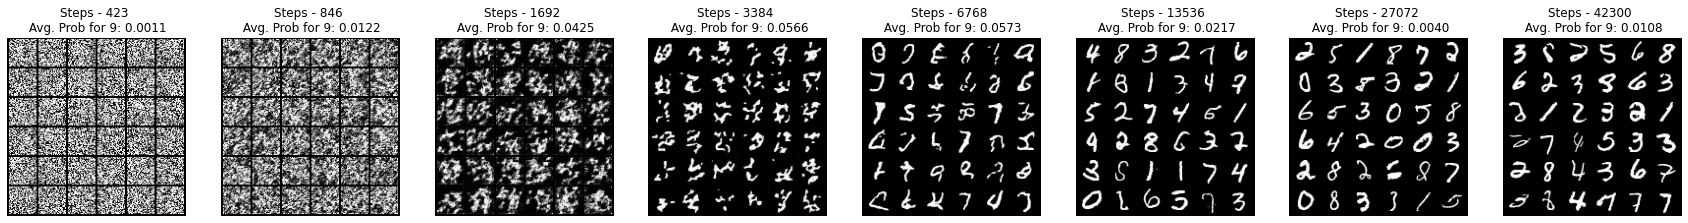

In [253]:
avg_prob = np.zeros((4, 9))

for i in range(1, 10):
    
    digits= i
    path = f"results/samples/unlearn_remaining_ablated/{digits}"

    # directory = path + "/epochs=100_datasets=False_loss=type1:alpha1=1.0_alpha2=0.05_weight_reg=False"
    # avg_prob[0, i-1] = plotting_mnist(directory, digits)

    directory = path + "/epochs=100_datasets=False_loss=type1:alpha1=1.0_alpha2=0.01_weight_reg=False"
    plotting_mnist(directory, digits)

#     directory = path + "/epochs=100_datasets=False_loss=type1:alpha1=1.0_alpha2=0.1_weight_reg=False"
#     avg_prob[2, i-1] = plotting_mnist(directory, digits)
    plotting_mnist(f"/projects/leelab2/mingyulu/unlearning/results/ablated/{digits}/samples", digits)

# directory = path + "/epochs=100_datasets=False_loss=type5:alpha1=1.0_alpha2=-0.05_weight_reg=False"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=100_datasets=False_loss=type5:alpha1=1.0_alpha2=-0.1_weight_reg=False"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=100_datasets=False_loss=type5:alpha1=1.0_alpha2=-0.3_weight_reg=False"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=100_datasets=False_loss=type4:alpha1=1.0_alpha2=0.05_weight_reg=False"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=100_datasets=False_loss=type4:alpha1=1.0_alpha2=0.1_weight_reg=False"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=100_datasets=False_loss=type4:alpha1=1.0_alpha2=0.3_weight_reg=False"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=100_datasets=False_loss=type3:alpha1=1.0_alpha2=0.7_weight_reg=False"
# plotting_mnist(directory, digits)

In [251]:
avg_prob.mean(axis=1)

array([0.03557464, 0.02675609, 0.05364832, 0.00499557])

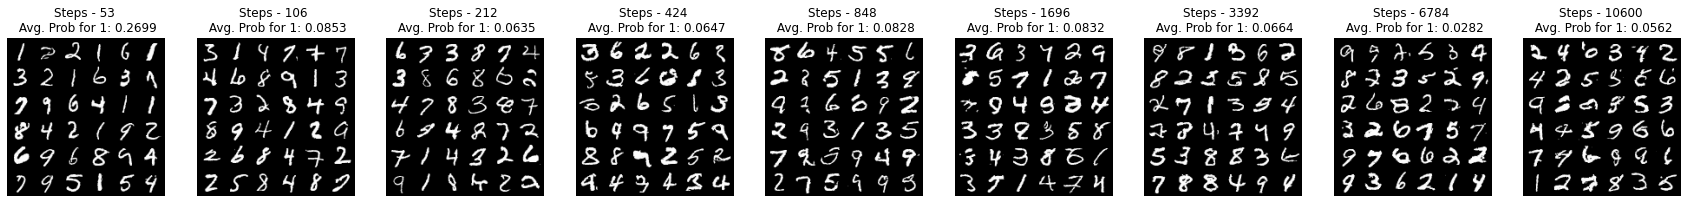

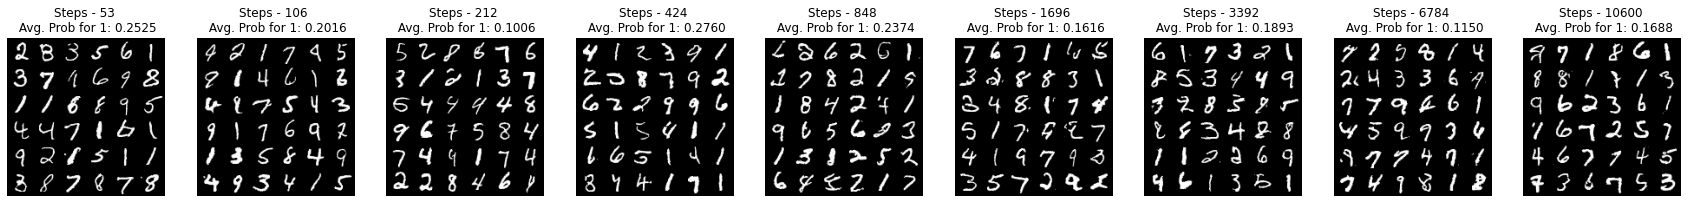

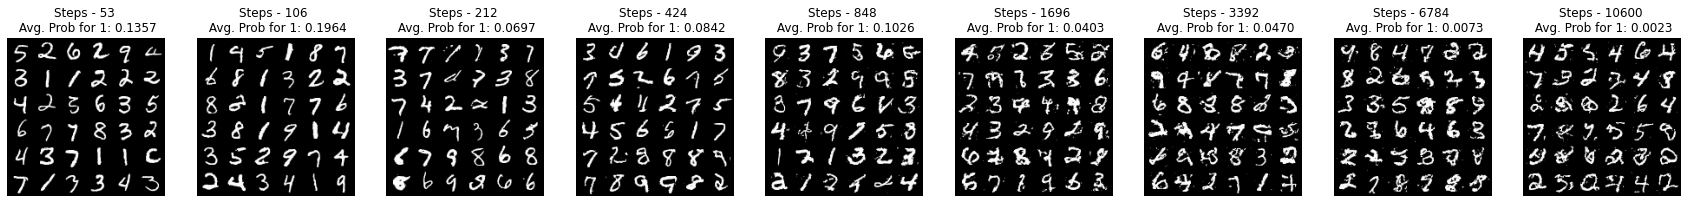

In [210]:
digits= 1
path = f"/projects/leelab2/mingyulu/unlearning/results/unlearn_remaining_ablated/{digits}"


# directory = path + "/epochs=200_datasets=False_loss=type5:alpha1=1_alpha2=-0.05_weight_reg=False/samples"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type5:alpha1=1.0_alpha2=-0.1_weight_reg=False/samples"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type5:alpha1=1.0_alpha2=-0.3_weight_reg=False/samples"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type4:alpha1=1.0_alpha2=1.0_weight_reg=True/samples"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type4:alpha1=1.0_alpha2=0.1_weight_reg=False/samples"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type3:alpha1=1.0_alpha2=0.05_weight_reg=False/samples"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type3:alpha1=1.0_alpha2=0.1_weight_reg=False/samples"
# plotting_mnist(directory, digits)


# # directory = path + "/epochs=200_datasets=False_loss=type1:alpha1=1_alpha2=0.2_weight_reg=True/samples"
# # plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type1:alpha1=1_alpha2=0.3_weight_reg=True/samples"
# plotting_mnist(directory, digits)


# directory = path + "/epochs=300_loss=type3:alpha1=1_alpha2=0.1/samples"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type2:alpha1=1_alpha2=0.3_weight_reg=True/samples"
# plotting_mnist(directory, digits)




# directory = path + "/epochs=300_loss=type3:alpha1=1_alpha2=0.1/samples"
# plotting_mnist(directory, digits)


# directory = path + "/epochs=200_datasets=False_loss=type2:alpha1=1_alpha2=0.3_weight_reg=True/samples"
# plotting_mnist(directory, digits)

# directory = path + "/epochs=200_datasets=False_loss=type1:alpha1=1_alpha2=0.5_weight_reg=True/samples"
# plotting_mnist(directory, digits)


directory = path+"/epochs=200_datasets=False_loss=type1:alpha1=1_alpha2=0.1/samples"
plotting_mnist(directory, digits)

directory = path + "/epochs=200_datasets=False_loss=type1:alpha1=1_alpha2=0.1_weight_reg=True/samples"
plotting_mnist(directory, digits)

directory = path + "/epochs=200_datasets=False_loss=type1:alpha1=1_alpha2=0.3_weight_reg=True/samples"
plotting_mnist(directory, digits)

# directory = path + "/epochs=300_loss=type4:alpha1=1_alpha2=0.1/samples"
# plotting_mnist(directory, digits)

# ground truth


# directory = f"full/samples"
# plotting_mnist(directory, cnn, device, digits)

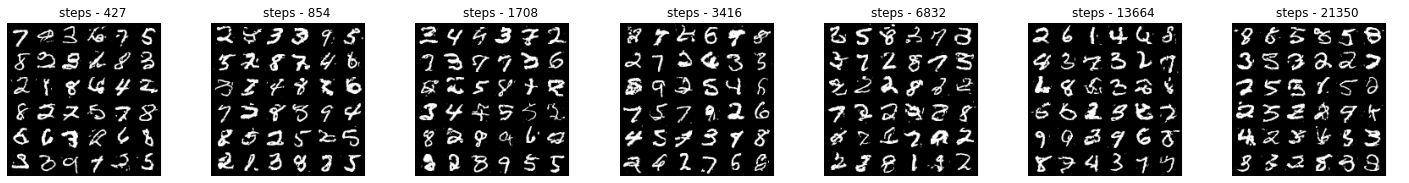

In [140]:
digits = 5

directory = f"unlearn_remaining_ablated/{digits}/epochs=50_datasets=False_loss=type1:alpha1=1_alpha2=0.2/samples"
plotting_mnist(directory)

# Removing with type 1 loss

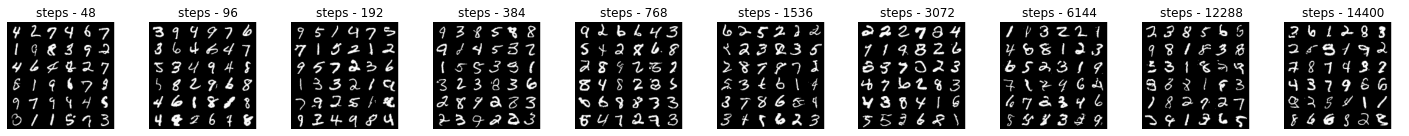

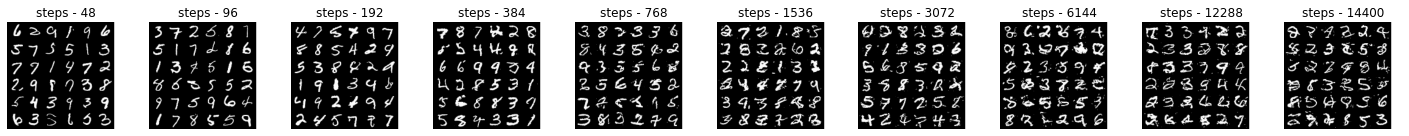

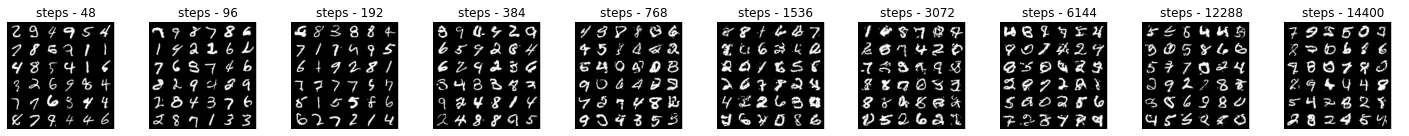

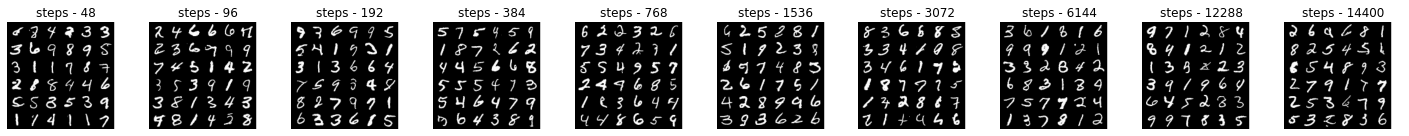

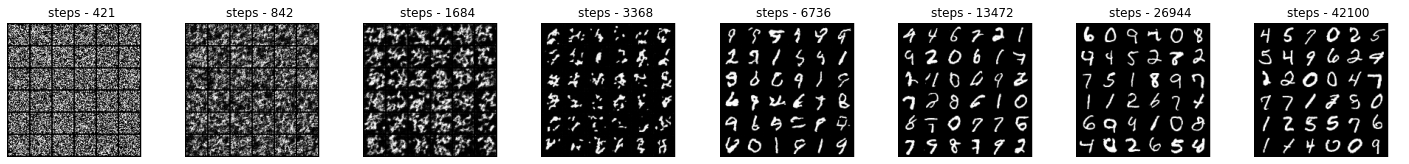

In [133]:
digits = 3

directory = f"unlearn_remaining_ablated/{digits}/epochs=300_loss=type1:alpha1=1_alpha2=0.1/samples"
plotting_mnist(directory)

directory = f"unlearn_remaining_ablated/{digits}/epochs=300_loss=type2:alpha1=1_alpha2=0.5/samples"
plotting_mnist(directory)

directory = f"unlearn_remaining_ablated/{digits}/epochs=300_loss=type3:alpha1=1_alpha2=0.1/samples"
plotting_mnist(directory)

directory = f"unlearn_remaining_ablated/{digits}/epochs=300_loss=type4:alpha1=1_alpha2=0.1/samples"
plotting_mnist(directory)

directory = f"ablated/{digits}/samples"
plotting_mnist(directory)

## Removing with type2 loss

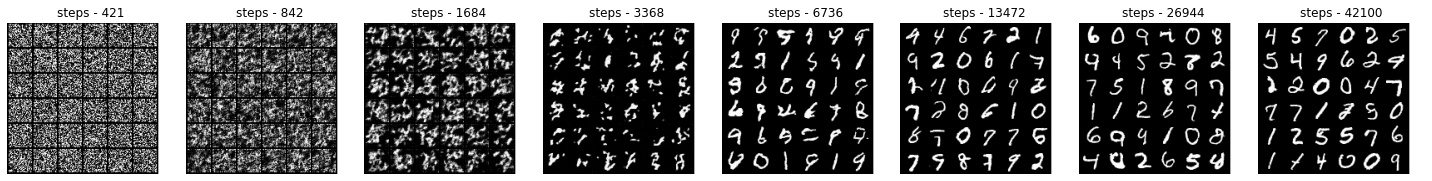

In [55]:
directory = f"ablated/{digits}/samples"

